This is what we have and we continue to do this for the next deadline you will give. Hopefully it will be after the exams, and we will submit our write up in github/report page as well.


Basic idea of our project is try to do spam email detection and first by using word count to count words for spam emails and other text files.

# Pyspark exploration

## Import dataset and setup the environment 

Note: It is different for different computers

In [13]:
from pyspark import SparkContext
import os 

# this should be JAVA_HOME path
os.environ['JAVA_HOME']="/Library/Java/JavaVirtualMachines/jdk1.8.0_202.jdk/Contents/Home/"

os.environ['PYSPARK_SUBMIT_ARGS'] = "--master local[2] pyspark-shell"

sc = SparkContext.getOrCreate()

In [14]:
data_file = "../data/labelled_dataset.csv.gz"
raw_data = sc.textFile(data_file).cache()

In [15]:
import pandas as pd
fixproblem = pd.read_csv(data_file)
fixproblem.head()

,label,txt
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("test").getOrCreate()

In [17]:
# it doesn't work well for some reason
df = spark.read.csv(data_file,header=True,inferSchema=True)
#df = spark.createDataFrame(fixproblem)

In [18]:
# from pyspark.sql.types import *

# mySchema =  StructType([ StructField("label", StringType(), True)\
#                       ,StructField("txt", StringType(), True)])
# data = spark.createDataFrame(fixproblem, schema = mySchema)

## DataFrame operations

### columns name

In [19]:
df.columns

['label', 'txt']

### Select column

In [20]:
df.txt

Column<b'txt'>

### Print Schema

In [21]:
df.printSchema()

root
 |-- label: string (nullable = true)
 |-- txt: string (nullable = true)



### Head 5

In [22]:
# Didn't strictly need a for loop, could have just then head()
for row in df.head(2):
    print(row)
    print('\n')

Row(label='ham', txt='Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')


Row(label='ham', txt='Ok lar... Joking wif u oni...')




In [23]:
df.describe().show()

+-------+--------------------+------------------+
|summary|               label|               txt|
+-------+--------------------+------------------+
|  count|             1970119|            840730|
|   mean|            Infinity|1023.1263393359594|
| stddev|                 NaN|  8450.10290912209|
|    min|                   !|                  |
|    max|⸪ Great Allowance...|        ”” said he|
+-------+--------------------+------------------+



### Word count and pyspark exploration

Although there are some trouble about the csv reading process, it works fine when we use subset of the dataset

In [25]:
df.filter("label == 'spam'").count()

877

In [36]:
df = df.filter("label == 'books' OR label == 'ham' OR label == 'spam'")

In [37]:
# https://stackoverflow.com/questions/48927271/count-number-of-words-in-a-spark-dataframe
import pyspark.sql.functions as f
data = df

### word count

In [38]:
# word count for each row
df = df.withColumn('wordCount', f.size(f.split(f.col('txt'), ' ')))
df.show()

+-----+--------------------+---------+
|label|                 txt|wordCount|
+-----+--------------------+---------+
|  ham|Go until jurong p...|       20|
|  ham|Ok lar... Joking ...|        6|
| spam|Free entry in 2 a...|       28|
|  ham|U dun say so earl...|       11|
|  ham|Nah I don't think...|       13|
| spam|FreeMsg Hey there...|       32|
|  ham|Even my brother i...|       16|
|  ham|As per your reque...|       26|
| spam|WINNER!! As a val...|       26|
| spam|Had your mobile 1...|       29|
|  ham|I'm gonna be home...|       21|
| spam|SIX chances to wi...|       26|
| spam|URGENT! You have ...|       26|
|  ham|I've been searchi...|       37|
|  ham|I HAVE A DATE ON ...|        8|
| spam|XXXMobileMovieClu...|       19|
|  ham|Oh k...i'm watchi...|        4|
|  ham|Eh u remember how...|       19|
|  ham|Fine if thatåÕs t...|       13|
| spam|England v Macedon...|       24|
+-----+--------------------+---------+
only showing top 20 rows



In [39]:
# total word
df.select(f.sum('wordCount')).collect() 

[Row(sum(wordCount)=127799)]

In [40]:
# see what type df is
type(df)

pyspark.sql.dataframe.DataFrame

In [41]:
# first 5 row
df.take(5)

[Row(label='ham', txt='Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', wordCount=20),
 Row(label='ham', txt='Ok lar... Joking wif u oni...', wordCount=6),
 Row(label='spam', txt="Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", wordCount=28),
 Row(label='ham', txt='U dun say so early hor... U c already then say...', wordCount=11),
 Row(label='ham', txt="Nah I don't think he goes to usf, he lives around here though", wordCount=13)]

In [42]:
df.show()

+-----+--------------------+---------+
|label|                 txt|wordCount|
+-----+--------------------+---------+
|  ham|Go until jurong p...|       20|
|  ham|Ok lar... Joking ...|        6|
| spam|Free entry in 2 a...|       28|
|  ham|U dun say so earl...|       11|
|  ham|Nah I don't think...|       13|
| spam|FreeMsg Hey there...|       32|
|  ham|Even my brother i...|       16|
|  ham|As per your reque...|       26|
| spam|WINNER!! As a val...|       26|
| spam|Had your mobile 1...|       29|
|  ham|I'm gonna be home...|       21|
| spam|SIX chances to wi...|       26|
| spam|URGENT! You have ...|       26|
|  ham|I've been searchi...|       37|
|  ham|I HAVE A DATE ON ...|        8|
| spam|XXXMobileMovieClu...|       19|
|  ham|Oh k...i'm watchi...|        4|
|  ham|Eh u remember how...|       19|
|  ham|Fine if thatåÕs t...|       13|
| spam|England v Macedon...|       24|
+-----+--------------------+---------+
only showing top 20 rows



### word count collection

In [43]:
# f.lower to convert captial words 
df.withColumn('word', f.explode(f.split(f.lower(f.col('txt')), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .show()

+----+-----+
|word|count|
+----+-----+
|  to| 2381|
|   i| 2215|
| the| 2185|
| you| 1917|
|   a| 1779|
|  of| 1143|
| and| 1134|
|  in| 1042|
|   u| 1030|
|  is|  944|
|    |  767|
|  my|  755|
| for|  725|
|call|  708|
|your|  674|
|  on|  608|
|  me|  605|
|have|  570|
|  it|  513|
| are|  512|
+----+-----+
only showing top 20 rows



In [44]:
word = df.withColumn('word', f.explode(f.split(f.lower(f.col('txt')), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)


In [45]:
to_list = [list(row) for row in word.collect()]

In [46]:
to_list

[['to', 2381],
 ['i', 2215],
 ['the', 2185],
 ['you', 1917],
 ['a', 1779],
 ['of', 1143],
 ['and', 1134],
 ['in', 1042],
 ['u', 1030],
 ['is', 944],
 ['', 767],
 ['my', 755],
 ['for', 725],
 ['call', 708],
 ['your', 674],
 ['on', 608],
 ['me', 605],
 ['have', 570],
 ['it', 513],
 ['are', 512],
 ['that', 479],
 ['at', 473],
 ['2', 453],
 ['or', 440],
 ['free', 436],
 ['so', 423],
 ['but', 420],
 ['send', 418],
 ['not', 405],
 ['with', 405],
 ['d', 395],
 ['can', 387],
 ['be', 384],
 ['email', 384],
 ['s', 381],
 ['ur', 379],
 ['if', 379],
 ['will', 377],
 ['get', 376],
 ["i'm", 376],
 ['address', 366],
 ['do', 365],
 ['our', 364],
 ['just', 363],
 ['order', 361],
 ['we', 344],
 ['one', 338],
 ['from', 324],
 ['this', 321],
 ['when', 284],
 ['want', 284],
 ['name', 281],
 ['&lt;#&gt;', 276],
 ['all', 276],
 ['please', 273],
 ['mail', 267],
 ['report', 265],
 ['up', 263],
 ['go', 262],
 ['receive', 262],
 ['no', 258],
 ['how', 257],
 ['day', 254],
 ['by', 251],
 ['now', 250],
 ['what', 25

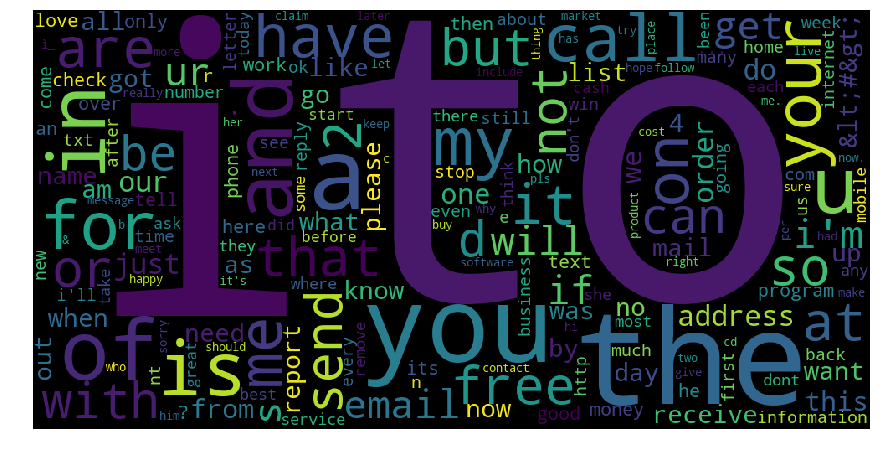

In [48]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from collections import Counter
# convert list to counter
temp = Counter(dict(to_list))
word_could_dict=Counter(temp)

# define stop words
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [49]:
to_list[1][0]
stopwords.update(["", "”", "-","—","'","or","."])

## Remove stop words

In [50]:
temp = [word for word in to_list if word[0] not in stopwords]
temp

[['u', 1030],
 ['call', 708],
 ['2', 453],
 ['free', 436],
 ['send', 418],
 ['d', 395],
 ['email', 384],
 ['s', 381],
 ['ur', 379],
 ['will', 377],
 ['address', 366],
 ['order', 361],
 ['one', 338],
 ['want', 284],
 ['name', 281],
 ['&lt;#&gt;', 276],
 ['please', 273],
 ['mail', 267],
 ['report', 265],
 ['go', 262],
 ['receive', 262],
 ['day', 254],
 ['now', 250],
 ['4', 249],
 ['got', 238],
 ['need', 237],
 ['list', 235],
 ['know', 230],
 ['program', 218],
 ['come', 217],
 ['work', 215],
 ['good', 203],
 ['money', 194],
 ['text', 187],
 ['?', 187],
 ['phone', 185],
 ['love', 183],
 ['tell', 183],
 ['check', 175],
 ['information', 174],
 ['back', 173],
 ['every', 172],
 ['time', 170],
 ['still', 168],
 ['week', 168],
 ['n', 165],
 ['ok', 164],
 ['...', 163],
 ['us', 162],
 ['reply', 162],
 ['going', 161],
 ['much', 156],
 ['number', 156],
 ['home', 155],
 ['nt', 154],
 ['even', 153],
 ['e', 153],
 ['new', 152],
 ['txt', 152],
 ['letter', 149],
 ['win', 148],
 ['business', 148],
 ['inte

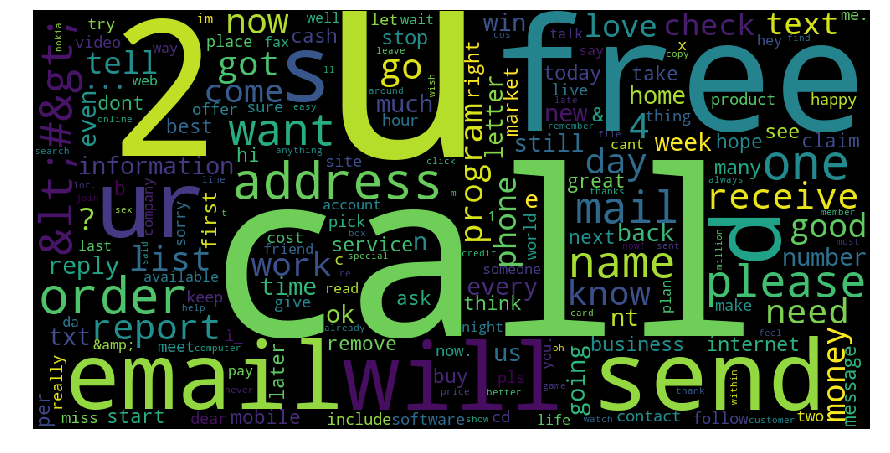

In [51]:
temp = Counter(dict(temp))
word_could_dict=Counter(temp)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## select ham

In [52]:
ham_df = df.where(df.label == 'ham')

In [53]:
ham_word = ham_df.withColumn('word', f.explode(f.split(f.lower(f.col('txt')), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)

In [54]:
ham_word.show()

+----+-----+
|word|count|
+----+-----+
|   i| 2171|
| you| 1665|
|  to| 1544|
| the| 1112|
|   a| 1043|
|   u|  873|
| and|  843|
|  in|  786|
|  my|  741|
|  is|  710|
|    |  597|
|  me|  584|
|  of|  518|
| for|  496|
|that|  442|
|  it|  440|
|have|  433|
|your|  413|
| but|  411|
| are|  405|
+----+-----+
only showing top 20 rows



In [55]:
to_list = [list(row) for row in ham_word.collect()]
temp = [word for word in to_list if word[0] not in stopwords]

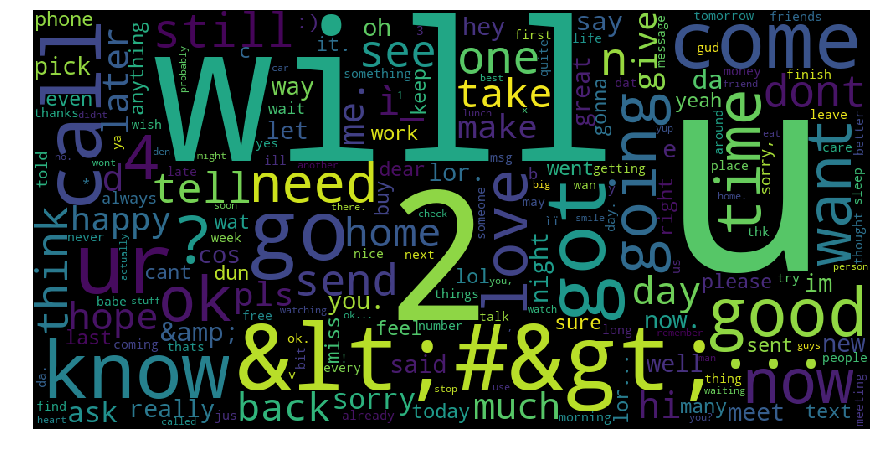

In [56]:
temp = Counter(dict(temp))
word_could_dict=Counter(temp)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## spam

In [57]:
spam_df = df.where(df.label == 'spam')

In [58]:
spam_word = spam_df.withColumn('word', f.explode(f.split(f.lower(f.col('txt')), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)

In [59]:
spam_word.show()

+-------+-----+
|   word|count|
+-------+-----+
|     to|  683|
|   call|  492|
|   free|  387|
|      a|  385|
|  email|  376|
|      s|  365|
|  order|  351|
|address|  350|
|    our|  303|
|      d|  302|
|   send|  297|
| report|  262|
|   your|  261|
|receive|  258|
|   name|  256|
|    you|  251|
|   mail|  250|
|   list|  229|
|program|  218|
| please|  208|
+-------+-----+
only showing top 20 rows



In [60]:
to_list = [list(row) for row in spam_word.collect()]
temp = [word for word in to_list if word[0] not in stopwords]

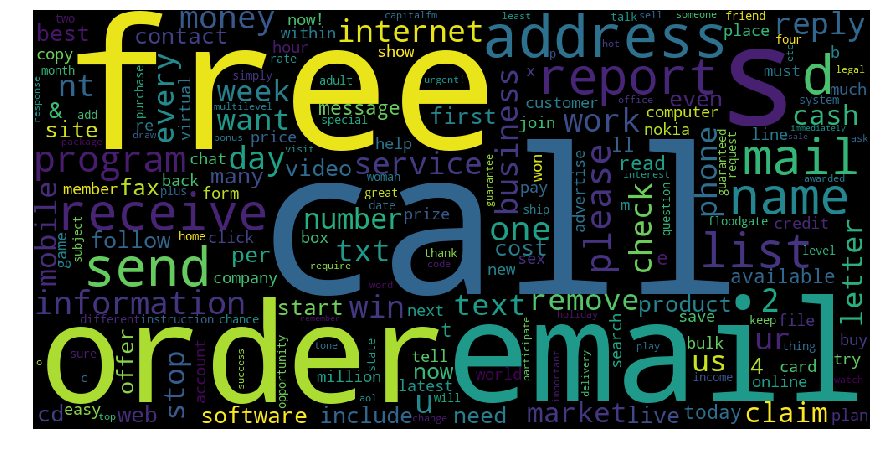

In [61]:
temp = Counter(dict(temp))
word_could_dict=Counter(temp)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

As you can see here: free, order are often used in spam emails

## Books

In [62]:
books_df = df.where(df.label == 'books')

In [63]:
books_word = books_df.withColumn('word', f.explode(f.split(f.lower(f.col('txt')), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)

In [64]:
books_word.show()

+---------+-----+
|     word|count|
+---------+-----+
|      the|  869|
|       of|  530|
|        a|  351|
|       in|  186|
|      and|  168|
|       to|  154|
|       an|  102|
|       on|   87|
|       by|   84|
|       at|   75|
|       as|   67|
|      or,|   61|
|      mr.|   53|
|       it|   48|
|     from|   47|
|       is|   47|
|      two|   34|
|      his|   32|
|performed|   32|
|     with|   28|
+---------+-----+
only showing top 20 rows



In [65]:
to_list = [list(row) for row in books_word.collect()]
temp = [word for word in to_list if word[0] not in stopwords]

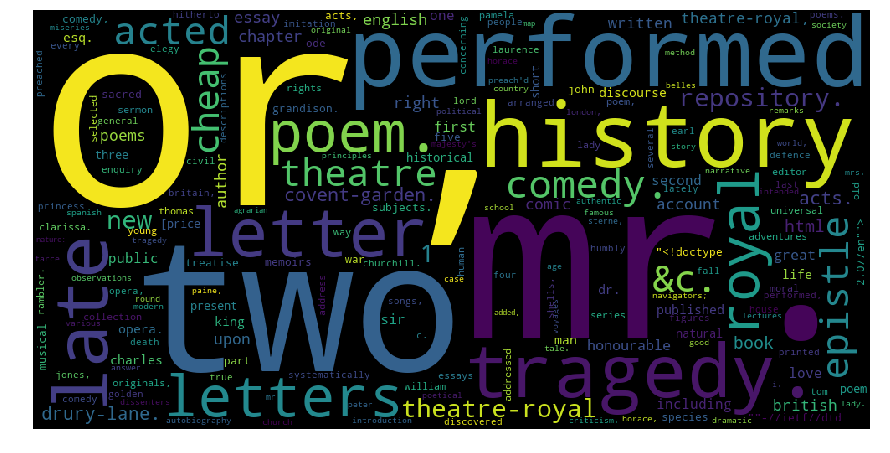

In [66]:
temp = Counter(dict(temp))
word_could_dict=Counter(temp)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Add a list of txt

In [67]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

tokenizer = Tokenizer(inputCol="txt", outputCol="words")

regexTokenizer = RegexTokenizer(inputCol="txt", outputCol="words", pattern="\\W")
# alternatively, pattern="\\w+", gaps(False)

countTokens = udf(lambda words: len(words), IntegerType())

tokenized = tokenizer.transform(df)

regexTokenized = regexTokenizer.transform(df)

regexTokenized.show()

+-----+--------------------+---------+--------------------+
|label|                 txt|wordCount|               words|
+-----+--------------------+---------+--------------------+
|  ham|Go until jurong p...|       20|[go, until, juron...|
|  ham|Ok lar... Joking ...|        6|[ok, lar, joking,...|
| spam|Free entry in 2 a...|       28|[free, entry, in,...|
|  ham|U dun say so earl...|       11|[u, dun, say, so,...|
|  ham|Nah I don't think...|       13|[nah, i, don, t, ...|
| spam|FreeMsg Hey there...|       32|[freemsg, hey, th...|
|  ham|Even my brother i...|       16|[even, my, brothe...|
|  ham|As per your reque...|       26|[as, per, your, r...|
| spam|WINNER!! As a val...|       26|[winner, as, a, v...|
| spam|Had your mobile 1...|       29|[had, your, mobil...|
|  ham|I'm gonna be home...|       21|[i, m, gonna, be,...|
| spam|SIX chances to wi...|       26|[six, chances, to...|
| spam|URGENT! You have ...|       26|[urgent, you, hav...|
|  ham|I've been searchi...|       37|[i

## Remove stop words

In [68]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
data = remover.transform(regexTokenized).show()

+-----+--------------------+---------+--------------------+--------------------+
|label|                 txt|wordCount|               words|            filtered|
+-----+--------------------+---------+--------------------+--------------------+
|  ham|Go until jurong p...|       20|[go, until, juron...|[go, jurong, poin...|
|  ham|Ok lar... Joking ...|        6|[ok, lar, joking,...|[ok, lar, joking,...|
| spam|Free entry in 2 a...|       28|[free, entry, in,...|[free, entry, 2, ...|
|  ham|U dun say so earl...|       11|[u, dun, say, so,...|[u, dun, say, ear...|
|  ham|Nah I don't think...|       13|[nah, i, don, t, ...|[nah, think, goes...|
| spam|FreeMsg Hey there...|       32|[freemsg, hey, th...|[freemsg, hey, da...|
|  ham|Even my brother i...|       16|[even, my, brothe...|[even, brother, l...|
|  ham|As per your reque...|       26|[as, per, your, r...|[per, request, me...|
| spam|WINNER!! As a val...|       26|[winner, as, a, v...|[winner, valued, ...|
| spam|Had your mobile 1...|

In [69]:
data = remover.transform(regexTokenized)

In [70]:
data.show()

+-----+--------------------+---------+--------------------+--------------------+
|label|                 txt|wordCount|               words|            filtered|
+-----+--------------------+---------+--------------------+--------------------+
|  ham|Go until jurong p...|       20|[go, until, juron...|[go, jurong, poin...|
|  ham|Ok lar... Joking ...|        6|[ok, lar, joking,...|[ok, lar, joking,...|
| spam|Free entry in 2 a...|       28|[free, entry, in,...|[free, entry, 2, ...|
|  ham|U dun say so earl...|       11|[u, dun, say, so,...|[u, dun, say, ear...|
|  ham|Nah I don't think...|       13|[nah, i, don, t, ...|[nah, think, goes...|
| spam|FreeMsg Hey there...|       32|[freemsg, hey, th...|[freemsg, hey, da...|
|  ham|Even my brother i...|       16|[even, my, brothe...|[even, brother, l...|
|  ham|As per your reque...|       26|[as, per, your, r...|[per, request, me...|
| spam|WINNER!! As a val...|       26|[winner, as, a, v...|[winner, valued, ...|
| spam|Had your mobile 1...|

In [71]:
data.select("txt").show()

+--------------------+
|                 txt|
+--------------------+
|Go until jurong p...|
|Ok lar... Joking ...|
|Free entry in 2 a...|
|U dun say so earl...|
|Nah I don't think...|
|FreeMsg Hey there...|
|Even my brother i...|
|As per your reque...|
|WINNER!! As a val...|
|Had your mobile 1...|
|I'm gonna be home...|
|SIX chances to wi...|
|URGENT! You have ...|
|I've been searchi...|
|I HAVE A DATE ON ...|
|XXXMobileMovieClu...|
|Oh k...i'm watchi...|
|Eh u remember how...|
|Fine if thatåÕs t...|
|England v Macedon...|
+--------------------+
only showing top 20 rows



In [73]:
from pyspark.sql.functions import monotonically_increasing_id

# This will return a new DF with all the columns + id
test = data # .select("filtered")
test = test.withColumn("id", monotonically_increasing_id())

test = test.filter("id<90 OR (id>=100 AND id<=1000) ")

In [75]:
from pyspark.ml.feature import Word2Vec

# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=10, minCount=0, inputCol="filtered", outputCol="result")
model = word2Vec.fit(test)

result = model.transform(test)


In [116]:
x_train = []
y_train = []
Label = []
for row in result.collect():
    label, text, words, filtered, identifier, vector = row
    print("Text: [%s] => \nLable: %s\nVector: %s\n" % (", ".join(filtered), label, str(vector)))
    x_train.append(vector)
    y_train.append(label)
    Label.append(label)

Text: [go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat] => 
Lable: ham
Vector: [0.022001760895363986,0.009336971706943586,0.012098487597540952,-0.01678768784040585,0.003958858513215091,0.045293996343389153,0.014861023897537962,-0.00532437302172184,-0.02280276728561148,0.0508610216784291]

Text: [ok, lar, joking, wif, u, oni] => 
Lable: ham
Vector: [0.033514234935864806,-0.005694398346046606,-0.0006820992566645145,-0.00023268070071935654,0.007649943853418032,0.08158993736530343,0.02822977133716146,-0.05292420368641615,-0.022683213154474892,0.08426036654661098]

Text: [free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receive, entry, question, std, txt, rate, c, apply, 08452810075over18] => 
Lable: spam
Vector: [0.041489395040553066,-0.0026939462358132006,0.006905663907527924,-0.005116446581669152,-0.0005762448022142053,0.030545900836586953,0.033301092507317664,-0.02926870517898351,0.0004101304104551

It doesn't work when the data are more than 100 for some reason

## KMeans classification

In [117]:
import numpy as np
x = np.asarray(x_train)

In [118]:
x[0]

array([ 0.02200176,  0.00933697,  0.01209849, -0.01678769,  0.00395886,
        0.045294  ,  0.01486102, -0.00532437, -0.02280277,  0.05086102])

In [119]:
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel

model = KMeans.train(
    sc.parallelize(x), 2, maxIterations=10, initializationMode="random",
    seed=50, initializationSteps=5, epsilon=1e-4)

1

In [174]:
for i in range(10):
    print("Prediction:"+ str(model.predict(x[i])), "True Label:" + str(Label[i]) )

Prediction:0 True Label:ham
Prediction:1 True Label:ham
Prediction:0 True Label:spam
Prediction:1 True Label:ham
Prediction:0 True Label:ham
Prediction:0 True Label:spam
Prediction:0 True Label:ham
Prediction:0 True Label:ham
Prediction:0 True Label:spam
Prediction:0 True Label:spam


## Logistic Regression

In [121]:
from pyspark.sql.types import IntegerType
indexer = StringIndexer(inputCol="label", outputCol="categorylabel")
indexed = indexer.fit(result).transform(result)
indexed.show()

+-----+--------------------+--------------------+--------------------+---+--------------------+-------------+
|label|                 txt|               words|            filtered| id|              result|categorylabel|
+-----+--------------------+--------------------+--------------------+---+--------------------+-------------+
|  ham|Go until jurong p...|[go, until, juron...|[go, jurong, poin...|  0|[0.02200176089536...|          0.0|
|  ham|Ok lar... Joking ...|[ok, lar, joking,...|[ok, lar, joking,...|  1|[0.03351423493586...|          0.0|
| spam|Free entry in 2 a...|[free, entry, in,...|[free, entry, 2, ...|  2|[0.04148939504055...|          1.0|
|  ham|U dun say so earl...|[u, dun, say, so,...|[u, dun, say, ear...|  3|[0.07958812742597...|          0.0|
|  ham|Nah I don't think...|[nah, i, don, t, ...|[nah, think, goes...|  4|[0.01469329890928...|          0.0|
| spam|FreeMsg Hey there...|[freemsg, hey, th...|[freemsg, hey, da...|  5|[0.03592335508146...|          1.0|
|  ham|Eve

In [150]:
indexed.show()

+-----+--------------------+--------------------+--------------------+---+--------------------+-------------+
|label|                 txt|               words|            filtered| id|              result|categorylabel|
+-----+--------------------+--------------------+--------------------+---+--------------------+-------------+
|  ham|Go until jurong p...|[go, until, juron...|[go, jurong, poin...|  0|[0.02200176089536...|          0.0|
|  ham|Ok lar... Joking ...|[ok, lar, joking,...|[ok, lar, joking,...|  1|[0.03351423493586...|          0.0|
| spam|Free entry in 2 a...|[free, entry, in,...|[free, entry, 2, ...|  2|[0.04148939504055...|          1.0|
|  ham|U dun say so earl...|[u, dun, say, so,...|[u, dun, say, ear...|  3|[0.07958812742597...|          0.0|
|  ham|Nah I don't think...|[nah, i, don, t, ...|[nah, think, goes...|  4|[0.01469329890928...|          0.0|
| spam|FreeMsg Hey there...|[freemsg, hey, th...|[freemsg, hey, da...|  5|[0.03592335508146...|          1.0|
|  ham|Eve

In [151]:
from pyspark.ml.classification import LogisticRegression
train, test = indexed.randomSplit([0.8, 0.2], seed = 7*4*25)

lr = LogisticRegression(featuresCol = 'result', labelCol = 'categorylabel', maxIter=10)
lrModel = lr.fit(train)

The coefficients

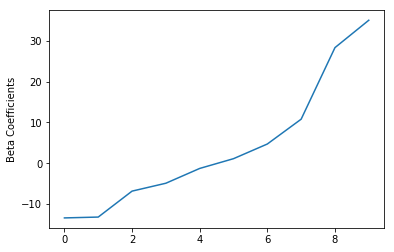

In [123]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

ROC

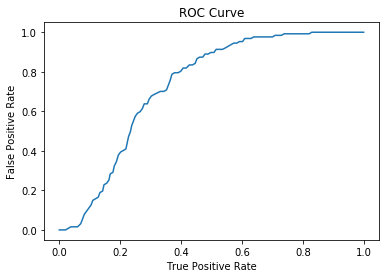

Training set areaUnderROC: 0.7284909870847641


In [124]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [126]:
predictions = lrModel.transform(test)
predictions.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  ham|       0.0|[0.99765082034717...|
|  ham|       0.0|[0.84105371698597...|
|  ham|       0.0|[0.89648348487724...|
|  ham|       0.0|[0.92001878523079...|
|  ham|       0.0|[0.90186312085611...|
|  ham|       0.0|[0.86995553279906...|
|  ham|       0.0|[0.98872121649465...|
|  ham|       0.0|[0.77740702508418...|
|  ham|       0.0|[0.95764545813179...|
|  ham|       0.0|[0.91866498363402...|
+-----+----------+--------------------+
only showing top 10 rows



In [136]:
indexed.show()

+-----+--------------------+--------------------+--------------------+---+--------------------+-------------+
|label|                 txt|               words|            filtered| id|              result|categorylabel|
+-----+--------------------+--------------------+--------------------+---+--------------------+-------------+
|  ham|Go until jurong p...|[go, until, juron...|[go, jurong, poin...|  0|[0.02200176089536...|          0.0|
|  ham|Ok lar... Joking ...|[ok, lar, joking,...|[ok, lar, joking,...|  1|[0.03351423493586...|          0.0|
| spam|Free entry in 2 a...|[free, entry, in,...|[free, entry, 2, ...|  2|[0.04148939504055...|          1.0|
|  ham|U dun say so earl...|[u, dun, say, so,...|[u, dun, say, ear...|  3|[0.07958812742597...|          0.0|
|  ham|Nah I don't think...|[nah, i, don, t, ...|[nah, think, goes...|  4|[0.01469329890928...|          0.0|
| spam|FreeMsg Hey there...|[freemsg, hey, th...|[freemsg, hey, da...|  5|[0.03592335508146...|          1.0|
|  ham|Eve

## Decision tree

In [172]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'result', labelCol = 'categorylabel', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('label','categorylabel','prediction', 'probability').show(10)

+-----+-------------+----------+--------------------+
|label|categorylabel|prediction|         probability|
+-----+-------------+----------+--------------------+
|  ham|          0.0|       0.0|[0.84282178217821...|
|  ham|          0.0|       0.0|[0.84282178217821...|
|  ham|          0.0|       0.0|[0.84282178217821...|
|  ham|          0.0|       0.0|[0.84282178217821...|
|  ham|          0.0|       0.0|[0.84282178217821...|
|  ham|          0.0|       0.0|[0.84282178217821...|
|  ham|          0.0|       0.0|[0.84282178217821...|
|  ham|          0.0|       0.0|[0.84282178217821...|
|  ham|          0.0|       0.0|[0.84282178217821...|
|  ham|          0.0|       0.0|[0.84282178217821...|
+-----+-------------+----------+--------------------+
only showing top 10 rows



In [173]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.labelCol :"categorylabel",evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5


## Random forest

In [153]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'result', labelCol = 'categorylabel')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  ham|       0.0|[0.99632792380117...|
|  ham|       0.0|[0.82469589138351...|
|  ham|       0.0|[0.89167003535195...|
|  ham|       0.0|[0.89837068180717...|
|  ham|       0.0|[0.78485421015852...|
|  ham|       0.0|[0.81832653494180...|
|  ham|       0.0|[0.99402023149348...|
|  ham|       0.0|[0.89006831808274...|
|  ham|       0.0|[0.99302500392975...|
|  ham|       0.0|[0.93907925607190...|
+-----+----------+--------------------+
only showing top 10 rows



In [171]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.labelCol :"categorylabel",evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8150815217391306


# Import different time with different size of unbalanced data

## Random data generator

In [1]:
import sys
sys.setrecursionlimit(150000)
sys.path.append('../documentation/encryption/')

from bitarray import bitarray
from MC import MarkovChain
from cryptography.fernet import Fernet

with open ("../books/3001.txt", "r", encoding="utf-8") as myfile:
    data = myfile.readlines()

m = MarkovChain()
# Learn the txt data
for i in data:
    m.learn(i)

length = 100
# Generate data with 100 words
print(m.babble(length))

 handledst pistols in the great a dryft
 enchaunted me:
 bloody staine,
 picht to him cunninglie,
 Why Mosbie my tale,
 meane to hire knaues,
 bloode we came it, hauing nought but went to be hangd vpon women, this the next encounters her,
 hir loue, without candle light,
 Perhaps I, the raylingest knaue is his time to your honest man will be slipt, til Ardens coming,
 whatsoeuer did serue me he liues.
 quitance with siluer dice:
 Me thinks me alone within,
 houes vs all.
 Tis childishnes to the Letter.
 land, weele haue you tell?
 beeing in a mist my cares he not


## Encryption and decryption part

In [2]:
# Encyption function by using Fernet
def Encrypt(data):
    # it needs a key first
    key = Fernet.generate_key()
    f = Fernet(key)
    # through the key we can do encryption and decryption as it is a symmetric algorithm
    ciphertext = f.encrypt(data)
    # return two variables key and encoded data
    return(key, ciphertext)
# Decryption
def Decrypt(key_ciphertext):
    ''' keyciphertext is a list which contains two elements
        index1: key, index2: encoded data'''
    # key = key_ciphertext[0]
    f = Fernet(key_ciphertext[0])
    # data = key_ciphertext[1]
    decrypttext = f.decrypt(key_ciphertext[1])
    return(decrypttext)

def Generator(Markov):
    return(Markov.babble(10000))

In [3]:
# An example of using Fernet to do encoding and decoding
data = Generator(m)
data = bytes(data, encoding = "utf-8")
key, ciphertext = Encrypt(data)
key_ciphertext = [key, ciphertext]
decrypttext = Decrypt(key_ciphertext)
print(decrypttext)

b" Doth challenge naught but to pick mens pockets in that I seeke to aprehend him\n Northeast wind,\n IN KENT.\n Nere longd so stout,\n content thee.\n cut him down Poules, til I list with a while, heer coms your good I haue his breast.\n answer you.\n wring me of,\n softly as securely, presently take you) that thou knowst that thou hast done, stand so soone.\n toppe bough of such a mist as I such aknaue as Greene, must go before, Ile seeke him drest,\n vyolate my grant,\n ouer kinde?\n silence such praiers as I,\n mine owne:\n blacke Will.\n ouerplus thats the sea,\n somewhat molyfied my brest.\n master of a weak to God,\n affraide, I not visit him?\n vrdged me with his fowle and now Bradshaw, Adam fowle,\n Shakebagge, canst thou thy selfe?\n howrs the Mariage of a worde,\n FEVERSHAM IN KENT.\n frend, shame scourgeth my husband.\n stifeled, that as wel deserue the more company comming after,\n Anothertime wele take no gould,\n through the Nages head, ther'is this deede.\n show some bo

We can change the size of the documents and percentage of the unbalanced data to do visualisation

In [4]:
# Run for large size of data
import time
import functools
timesaver = []
for j in range(1000,5000,1000):
    # dataset to save all the documents. (documents are both like the example above)
    dataset = []
    # generate the dataset
    data = Generator(m)
    # transfer to bytes type
    data = bytes(data, encoding = "utf-8")
    # dataset repeat data for j times to get j documents
    # if j = 1000, dataset contains 1000 documents
    # The task is to encode and decode 1000 documents 
    # ps: each document contains 10000 words
    for i in range(j):
        dataset.append(data)
    
    # start to do encryption and decrytion
    start_time = time.time()
    # encoding
    test = list(map(Encrypt,dataset))
    # decoding
    decoded = list(map(Decrypt,test))
    # count the end time and print it
    end_time = time.time() - start_time
    print(end_time)
    # save it to timesaver for visulisation
    timesaver.append(end_time)

0.8899860382080078
1.7107620239257812
2.45750093460083
3.237651824951172


In [5]:
# import time.pickle contains the timesaver for different 
import pickle
with open('../data/timedata/time.pickle', 'rb') as f:
    timesaver = pickle.load(f)

In [ ]:
# import the data generated before

Details can be found here: https://github.com/samanthawise/dstassignment5/tree/master/documentation/

In [6]:
import numpy as np
import pickle
with open('../data/timedata/time_balanced.pickle', 'rb') as f:
    # balanced data
    timesaver_b = pickle.load(f)
with open('../data/timedata/time_unbalanced.pickle', 'rb') as f:
    # unbalanced data with 50% large size and 50% small size
    timesaver_u = pickle.load(f)
with open('../data/timedata/time_unbalanced_10.pickle', 'rb') as f:
    timesaver_u10 = pickle.load(f)
with open('../data/timedata/time_unbalanced_20.pickle', 'rb') as f:
    timesaver_u20 = pickle.load(f)
with open('../data/timedata/time_unbalanced_30.pickle', 'rb') as f:
    timesaver_u30 = pickle.load(f)
with open('../data/timedata/time_unbalanced_40.pickle', 'rb') as f:
    timesaver_u40 = pickle.load(f)
with open('../data/timedata/time_unbalanced_60.pickle', 'rb') as f:
    timesaver_u60 = pickle.load(f)
with open('../data/timedata/time_unbalanced_70.pickle', 'rb') as f:
    timesaver_u70 = pickle.load(f)
with open('../data/timedata/time_unbalanced_80.pickle', 'rb') as f:
    timesaver_u80 = pickle.load(f)
with open('../data/timedata/time_unbalanced_90.pickle', 'rb') as f:
    timesaver_u90 = pickle.load(f)
with open('../data/timedata/time_unbalanced_100.pickle', 'rb') as f:
    timesaver_u100 = pickle.load(f)


## Visualisation

In [ ]:
### Fix the length of every documents,

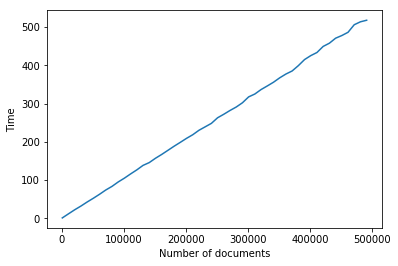

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(1000,500000,10000), timesaver)
plt.xlabel('Number of documents')
plt.ylabel('Time')
plt.show()

In [ ]:
# Maybe explain it, for example:
# with the number of documents increase the time increase linearly

In [ ]:
# unbalanced data means there contains 1000 words and 100000 words in different documents
# eg. unbalanced_10% represents:
# 10% documents have 1000 words and 90% of them have 100000 words

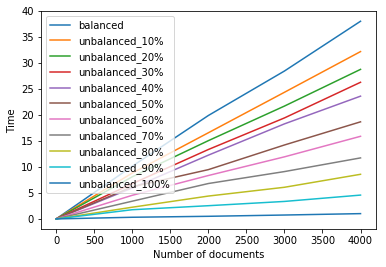

In [55]:
%matplotlib inline

plt.figure()
l2, = plt.plot(np.arange(0,5000,1000), timesaver_b)
l3, = plt.plot(np.arange(0,5000,1000), timesaver_u10)
l4, = plt.plot(np.arange(0,5000,1000), timesaver_u20)
l5, = plt.plot(np.arange(0,5000,1000), timesaver_u30)
l6, = plt.plot(np.arange(0,5000,1000), timesaver_u40)
l7, = plt.plot(np.arange(0,5000,1000), timesaver_u)
l8, = plt.plot(np.arange(0,5000,1000), timesaver_u60)
l9, = plt.plot(np.arange(0,5000,1000), timesaver_u70)
l10, = plt.plot(np.arange(0,5000,1000), timesaver_u80)
l11, = plt.plot(np.arange(0,5000,1000), timesaver_u90)
l12, = plt.plot(np.arange(0,5000,1000), timesaver_u100)

plt.xlabel('Number of documents')
plt.ylabel('Time')
plt.legend((l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12), ('balanced', 'unbalanced_10%', 'unbalanced_20%', 'unbalanced_30%', 'unbalanced_40%', 'unbalanced_50%', 'unbalanced_60%', 'unbalanced_70%', 'unbalanced_80%', 'unbalanced_90%', 'unbalanced_100%'))

# maybe it is too much lines, I chose different 
plt.show()

In [ ]:
# Analysis: Maybe this graph is not clear go to the end of the documents



TODO: Maybe we can calculate the slope or something?
TODO: Maybe can calculate if the time just depends on total words

In [ ]:
# 10000 documents (fix the number of documents)
# see how it changes with different size of documents

In [10]:
with open('../data/time_with_prob.pickle', 'rb') as f:
    timesaver_p = pickle.load(f)

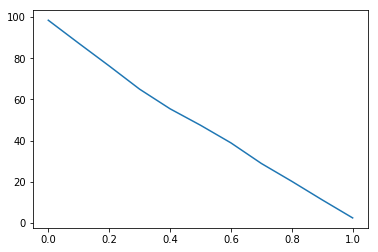

In [11]:
# from 0 to 1, use prob because I generate the data by using random variable x 
# if x < prob, it generate the documents with 1000 words, if not generate a large one
prob = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
plt.plot(prob, timesaver_p)

In [ ]:
# basically like linear

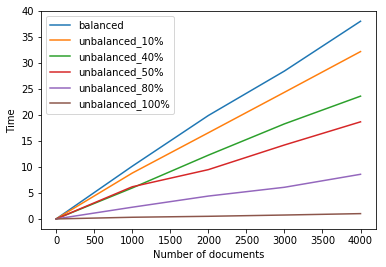

In [56]:
%matplotlib inline

plt.figure()
l2, = plt.plot(np.arange(0,5000,1000), timesaver_b)
l3, = plt.plot(np.arange(0,5000,1000), timesaver_u10)
l6, = plt.plot(np.arange(0,5000,1000), timesaver_u40)
l7, = plt.plot(np.arange(0,5000,1000), timesaver_u)
l10, = plt.plot(np.arange(0,5000,1000), timesaver_u80)
l12, = plt.plot(np.arange(0,5000,1000), timesaver_u100)

plt.xlabel('Number of documents')
plt.ylabel('Time')
plt.legend((l2, l3, l6, l7, l10, l12), ('balanced', 'unbalanced_10%', 'unbalanced_40%', 'unbalanced_50%','unbalanced_80%', 'unbalanced_100%'))

plt.show()

In [ ]:
# The 40% 50% is interesting. don't know if it is a coincidence

In [ ]:
# Just let me know what kind of graph you want: maybe can try different number of cores

# Draft(skip this part)

In [135]:
df.withColumn('list', df['txt'].split(" ")).show()

TypeError: 'Column' object is not callable

In [141]:
split_col = f.split(df['txt'], ' ')

In [152]:
data = data.withColumn('NAME1', split_col.getItem(0))
data = data.withColumn('NAME2', split_col.getItem(1))



In [5]:
data.show()

NameError: name 'data' is not defined

In [116]:
df.withColumn('word', f.explode(f.split(f.col('txt'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .show()

+----+------+
|word| count|
+----+------+
|    |784389|
| the|282718|
| and|194113|
|  of|163358|
|  to|145701|
|   a|103066|
|  in| 90602|
|   I| 88815|
|that| 72731|
|  he| 53735|
| his| 48351|
|  it| 46497|
|  as| 46428|
|with| 45537|
| was| 45149|
|  is| 43232|
| you| 42713|
| for| 41989|
|  my| 39440|
|  be| 37498|
+----+------+
only showing top 20 rows



In [117]:
from pyspark.ml.feature import StopWordsRemover


In [95]:
text_file = sc.textFile("../books/*.txt")


In [91]:
text_file.count()

6003218

In [16]:
from pyspark.ml.feature import CountVectorizer

# Input data: Each row is a bag of words with a ID.
df = spark.createDataFrame([
    (0, "a b c".split(" ")),
    (1, "a b b c a".split(" "))
], ["id", "words"])

# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="words", outputCol="features", vocabSize=3, minDF=2.0)

model = cv.fit(df)

result = model.transform(df)
result.show(truncate=False)

print((df.count(), len(df.columns)))


+---+---------------+-------------------------+
|id |words          |features                 |
+---+---------------+-------------------------+
|0  |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|
|1  |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|
+---+---------------+-------------------------+

(2, 2)
